# Full Cooling Calculation

We are now ready to demonstrate the full cooling calculation, starting from an injection of high-energy electrons and photons, and ending in an integrated ionization and thermal history that results from this injection. 

## Initialization

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [23]:
%autoreload
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [10,10]

import numpy as np
import pickle
import darkhistory.physics as phys
import darkhistory.spec.spectools as spectools
from darkhistory.spec.spectrum import Spectrum
import darkhistory.history.tla as tla

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec
from darkhistory.electrons.ics.ics_cooling import get_ics_cooling_tf

import darkhistory.low_energy.lowE_electrons as lowE_electrons
import darkhistory.low_energy.lowE_photons as lowE_photons

np.set_printoptions(threshold=np.nan)

## Inputs

The inputs of the code are as follows: 

1. A `Spectrum` or `Spectra` object containing the injected electron spectrum, or the injected electron spectrum as a function of redshift, and/or 

2. A `Spectrum` or `Spectra` object containing the injected photon spectrum, or the injected photon spectrum as a function of redshift.

There are 3 modes of use. For a `Spectrum` input, the spectrum can be interpreted either as a single injection at a particular redshift, and no subsequent injections, or as a spectrum with the redshift dependence factored out, with a continuous injection at every step. For a `Spectra` input, the spectrum at each redshift step is injected. 

We will start with the single injection case here. As an example, we begin with a $\delta$-function injection of two 1 MeV electrons at some arbitrary energy, start at redshift $1+z = 2000$. Let's first initialize the spectrum. 

In [24]:
eleceng = np.logspace(1, 13, 100)
photeng = np.logspace(-4, 13, 100)
rs = 5

elec_spec_init = spectools.rebin_N_arr(np.array([1]), 
                                      np.array([1e12]),
                                      eleceng)

elec_spec_init.rs = rs

## Resolving Injected Electrons

High energy electrons ($\gg$ keV) primarily cool by inverse compton scattering (ICS), at a rate that is much faster than the smallest timestep allowable in this code ($\Delta \log (1+z) = 10^{-3}$). Lower energy electrons also cool quickly, but via atomic processes.

Low energy electrons ($< 3.5$ keV) are read out immediately and saved in a `Spectra` object. High energy electrons will be converted into a photon spectrum through ICS, and an estimate for the energy loss due to atomic cooling also produced. 

For now, we will assume only ICS for high energy electrons. 

In [25]:
user="gridgway"
raw_nonrel_ICS_tf = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/ICS_nonrel.raw","rb"))
raw_rel_ICS_tf = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/ICS_rel.raw","rb"))
raw_engloss_tf = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/ICS_englossspec.raw","rb"))

(ics_phot_tf, ics_lowengelec_tf) = get_ics_cooling_tf(raw_nonrel_ICS_tf,
                                                     raw_rel_ICS_tf,
                                                     raw_engloss_tf,
                                                     eleceng, photeng, rs)

In [26]:
phot_spec_init = spectools.scatter(ics_phot_tf, elec_spec_init, new_eng=photeng)

## Photon Cooling

Now we cool the photons that result from the high energy electron injection. Photons below 3.1 keV are considered low energy photons. For high energy photons, greater than 3.1 keV, we have transfer functions (a function of *both* injected photon energy and redshift, so they are given as a `TransFuncList`), into high energy photons, low energy photons and low energy electrons. Let's load them first. 

In [27]:
highengphot_tflist = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tfunclist_photspec.raw", "rb"))
lowengphot_tflist  = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tfunclist_lowengphotspec.raw", "rb"))
lowengelec_tflist  = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tfunclist_lowengelecspec.raw", "rb"))

In [28]:
# This shouldn't be necessary. There is one negative value somewhere. Check.
for tf in highengphot_tflist:
    tf.grid_vals[np.where(tf.grid_vals < 0)] = 0
for tf in lowengphot_tflist:
    tf.grid_vals[np.where(tf.grid_vals < 0)] = 0


We now need to construct a transfer function list for *both* high- and low-energy photons. It needs to be a square matrix (so that we can take powers of the matrix for coarsening later), with dimensions given by the length of `photeng`.

In [29]:
#Split photeng into high and low energy. 
photeng_high = photeng[photeng > 3070]
photeng_low  = photeng[photeng <= 3070]

# Split eleceng into high and low energy. 
eleceng_high = eleceng[eleceng > 3500]
eleceng_low  = eleceng[eleceng <= 3500]

# highengphot_tflist.in_eng set to photeng_high
highengphot_tflist.at_val('in_eng', photeng_high, bounds_error=False, fill_value=0)
for tf in highengphot_tflist:
    tf.rebin(photeng_high)
    # Pad with zeros so that it becomes photeng x photeng. 
    tf._grid_vals = np.pad(tf.grid_vals, ((photeng_low.size, 0), (photeng_low.size, 0)), 'constant')
    tf._N_underflow = np.pad(tf._N_underflow, (photeng_low.size, 0), 'constant')
    tf._eng_underflow = np.pad(tf._eng_underflow, (photeng_low.size, 0), 'constant')
    tf._in_eng = photeng
    tf._eng = photeng
highengphot_tflist.eng = photeng
highengphot_tflist.in_eng = photeng
    
# lowengphot_tflist.in_eng set to photeng_high
lowengphot_tflist.at_val('in_eng', photeng_high, bounds_error=False, fill_value=0)
for tf in lowengphot_tflist:
    tf.rebin(photeng)
    # Pad with zeros so that it becomes photeng x photeng. 
    tf._grid_vals = np.pad(tf.grid_vals, ((photeng_low.size,0), (0,0)), 'constant')
    tf._in_eng = photeng
    tf._eng = photeng
lowengphot_tflist.eng = photeng
lowengphot_tflist.in_eng = photeng
    
# lowengelec_tflist.in_eng set to photeng_high 
lowengelec_tflist.at_val('in_eng', photeng_high, bounds_error=False, fill_value=0)
for tf in lowengelec_tflist:
    tf.rebin(eleceng)
    # Pad with zeros so that it becomes photeng x eleceng. 
    tf._grid_vals = np.pad(tf.grid_vals, ((photeng_low.size,0), (0,0)), 'constant')
    tf._in_eng = photeng
    tf._eng = eleceng
lowengelec_tflist.eng = eleceng
lowengelec_tflist.in_eng = photeng
    

We need to decide on the redshift step to use. The default redshift step in the transfer functions is $d \log (1+z) = 2 \times 10^{-3}$, with the transfer function evaluated at (currently) 50 redshifts, from $1+z = 30$ to $1+z=4$, so that the transfer function with $d \log(1+z) = 2 \times 10^{-3}$ can be interpolated between them. However, we can coarsen the high energy photon transfer function by some factor $f$ by multiplying the transfer function matrix by itself multiple times, producing transfer functions for a redshift step of $d \log (1+z) = f \times 2 \times 10^{-3}$. 

In [30]:
# The redshift step to use will be coarsen_factor * 0.002
coarsen_factor = 5
# Generate the redshifts at which we want to get an interpolated value for the transfer function. 
tf_rs_arr = highengphot_tflist.rs
rs_list = np.exp(np.arange(np.log(tf_rs_arr[0]), 
                           np.log(tf_rs_arr[-1]), 
                           -highengphot_tflist.dlnz*coarsen_factor)
                )

if coarsen_factor > 1:
    lowengphot_tflist.coarsen(coarsen_factor, delete_tfs=False, coarsen_type='dep', prop_transfunclist=highengphot_tflist)
    lowengelec_tflist.coarsen(coarsen_factor, delete_tfs=False, coarsen_type='dep', prop_transfunclist=highengphot_tflist)
    highengphot_tflist.coarsen(coarsen_factor, delete_tfs=False)
    

lowengphot_tflist.at_val('rs',rs_list)
lowengelec_tflist.at_val('rs',rs_list)
highengphot_tflist.at_val('rs',rs_list)


In [31]:
# spectools.evolve for lowengphot and lowengelec are incorrect, propagation needs to be done using highengphot_tflist.
highengphot_spec_final = spectools.evolve(phot_spec_init, highengphot_tflist, end_rs=29)
lowengphot_spec_final  = spectools.evolve(phot_spec_init, lowengphot_tflist,  end_rs=29)
lowengelec_spec_final  = spectools.evolve(phot_spec_init, lowengelec_tflist,  end_rs=29)

# Low Energy Electrons and Photons

Given the final low energy electron and photon spectra, we can now calculate the fraction of energy that the electrons deposit in heating the IGM(?), lyman-$\alpha$ transitions, ionizing H, ionizing He, and continuum photons.

In [111]:
#   For testing purposes, set arbitrary parameters. At redshift 3000, suppose xHII = .5, and the
#total dark matter injection rate is split between a delta function electron energy rate and the same
#delta function photon energy rate.
rs0 = 3000

def dm_injection_rate(rs):
    # Set the desired lifetime here in seconds. 
    tau = 1e27
    return phys.rho_DM*rs**3/tau

tot_inj = dm_injection_rate(rs0)

eng = 10**((np.arange(100)-70)*(1/10))
Ns = np.zeros(100)
Ns[30] = tot_inj/2
lowengphot_spec_final = Spectrum(eng, Ns, rs0, spec_type='N')
lowengelec_spec_final = Spectrum(eng, Ns, rs0, spec_type='N')

In [119]:
# WORRIES: (1) These f_c(z) functions are not optimized
#          (2) I have switched from xe to xHII
#          (3) Both compute_dep_inj_ratio functions assume that Spectrum.N returns number density per unit time
#          (4) lowE_photons.compute_dep_inj_ratio needs [n_H,n_HeI,n_HeII] as input, not x_HII.
#          (5) Can photons contribute to heating?  Heating of what, IGM?

rs0=3000
rs_final = 1
xHII = .5
xHeI = 0
xHeII = 0
nH=phys.nH

def f_H_ion(rs, xHII):
    photon = lowE.lowE_photons.compute_dep_inj_ratio(lowengphot_spec_final,np.array([xHII,xHeI,xHeII])*nH,tot_inj)[2]
    electron = lowE.lowE_electrons.compute_dep_inj_ratio(lowengelec_spec_final,xHII,tot_inj)[2]
    return electron + photon

def f_H_exc(rs, xHII):
    electron = lowE.lowE_electrons.compute_dep_inj_ratio(lowengelec_spec_final,xHII,tot_inj)[1]
    photon = lowE.lowE_photons.compute_dep_inj_ratio(lowengphot_spec_final,np.array([xHII,xHeI,xHeII])*nH,tot_inj)[1]
    return electron + photon

def f_heating(rs, xHII):
    return lowE.lowE_electrons.compute_dep_inj_ratio(lowengelec_spec_final,xHII,tot_inj)[0]

# Initialize the redshift at which we want the solution. 
rs_vec = np.flipud(1 + np.arange(rs_final,rs0,1))

# Set the initial conditions. The initial temperature is the CMB temperature, 
# and the initial free electron fraction is 1. Strictly speaking, the code
# changes 1 to 1 - 1e-12, as otherwise y is infinite.
init_cond = [phys.TCMB(rs0), 1, 0, 0]

# Obtain the solution
soln = tla.get_history(init_cond, f_H_ion, f_H_exc, f_heating, dm_injection_rate, rs_vec, reion_switch=False)

[1, 3000.0, 0.0001, 2]

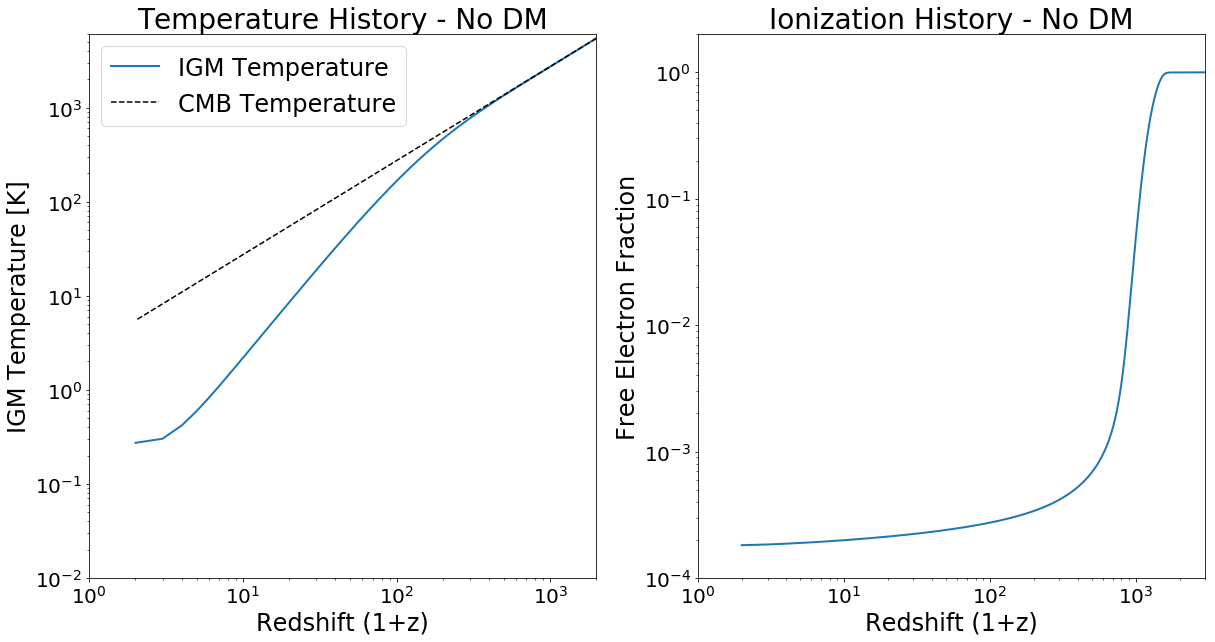

In [120]:
plt.figure(figsize=(20,10))

ax = plt.subplot(1,2,1)
#plt.rc('text', usetex=False)

T_IGM, = plt.plot(rs_vec, soln[:,0]/phys.kB, linewidth=2, label='IGM Temperature')
T_CMB, = plt.plot(rs_vec, phys.TCMB(rs_vec)/phys.kB, 'k--', label='CMB Temperature')

ax.set_xscale('log')
ax.set_yscale('log')

plt.legend(handles=[T_IGM, T_CMB], 
           fontsize=24)

plt.tick_params(axis='both', which='major', labelsize=20)

plt.title('Temperature History - No DM', fontsize=28)
plt.xlabel('Redshift (1+z)',fontsize=24)
plt.ylabel('IGM Temperature [K]',fontsize=24)
plt.axis([1, 2e3, 1e-2, 6e3])

ax = plt.subplot(1,2,2)
#plt.rc('text', usetex=False)

plt.plot(rs_vec, soln[:,1], linewidth=2)

ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.title('Ionization History - No DM', fontsize=28)
plt.xlabel('Redshift (1+z)',fontsize=24)
plt.ylabel('Free Electron Fraction',fontsize=24)
plt.axis([1, 3e3, 1e-4, 2])


# TLA Integration

In [31]:
print(rs_list)

[ 31.          30.69154485  30.38615887  30.08381154  29.78447261
  29.48811216  29.19470054  28.90420842  28.61660674  28.33186674
  28.04995996  27.77085819  27.49453354  27.22095836  26.9501053
  26.68194727  26.41645746  26.15360931  25.89337655  25.63573315
  25.38065335  25.12811163  24.87808274  24.63054168  24.38546369
  24.14282428  23.90259916  23.66476432  23.42929599  23.19617059
  22.96536484  22.73685564  22.51062015  22.28663574  22.06488001
  21.84533078  21.62796611  21.41276425  21.19970369  20.98876311
  20.77992143  20.57315775  20.36845141  20.16578194  19.96512905
  19.7664727   19.56979301  19.37507032  19.18228515  18.99141822
  18.80245045  18.61536294  18.43013699  18.24675406  18.06519582
  17.88544412  17.70748098  17.5312886   17.35684936  17.18414583
  17.01316072  16.84387694  16.67627757  16.51034583  16.34606515
  16.18341908  16.02239137  15.86296591  15.70512676  15.54885814
  15.39414442  15.24097012  15.08931993  14.93917869  14.79053138
  14.643363

In [29]:
print(phot_spec_init)
print(highengphot_spec_final.dNdE)
print(lowengphot_spec_final.dNdE)
print(lowengelec_spec_final.dNdE)

[ 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  6.7513011e-33  1.4776637e-31  5.3655541e-30  3.0703887e-34  2.3636385e-34
  9.0714554e-35  8.7063589e-35  3.4031057e-35  9.2303588e-35  9.2870429e-36
  5.8325168e-36  2.7054205e-36  1.314924e-36  7.1402223e-37  4.5527966e-37
  7.9541725e-37  2.1327243e-37  1.2788171e-37  4.0604472e-38  1.8930739e-38
  1.7513158e-38  5.1230924e-39  5.7748128e-39  1.4219864e-39  6.5360556e-40
  4.3440896e-40  1.5522027e-40  6.5895969e-41  4.3267794e-41  1.1262991e-41
  9.3818284e-42  2.3946115e-40  2.0476465e-43  2.058335e-44  1.3287796e-45
  1.9060029e-45  9.895211e-48  7.1453397e-48  1.9940999e-47  6.1497206e-46
  2.1109143e-44  1.6470299e-42  1.6311045e-40  6.2329094e-56  1.1704678e-54
  7.8970102e-53  3.3970708e-51  3.1143292e-74  3.9039551e-107
  2.3738152e-188  5.8121111e-195  